# 안녕하세요^^ 
# AIVLE 미니 프로젝트에 오신 여러분을 환영합니다.
* 본 과정에서는 실제 사례와 데이터를 기반으로 문제를 해결하는 전체 과정을 자기 주도형 실습으로 진행해볼 예정입니다.
* 앞선 교육과정을 정리하는 마음과 지금까지 배운 내용을 바탕으로 문제 해결을 해볼게요!
* 미니 프로젝트를 통한 문제 해결 과정 'A에서 Z까지', 지금부터 시작합니다!

# __[Study] 4. JSON, XML 등 YOLO와 다른 라벨 포맷 데이터 파싱하기__
- Parsing?<br>
JSON, XML 등에서 내가 원하는 데이터를 특정 패턴이나 순서로 추출하여 정보로 가공하는 것을 말합니다.<br>
'공공 데이터 포탈', 'AI HUB', '서울시 열린데이터' 등 제공하는 데이터들이 보통 .JSON 파일 포맷으로 이미지가 라벨링되어 있으며, <br>
라벨링 된 패턴이 데이터마다 상이하여 JSON 파일을 탐색하고 <br>
YOLOv5 라벨 데이터 .txt(class_id center_x center_y Dw Dh) 형태로 Convert하는 작업이 필요함. 

- 실습 파일 4번은 AI HUB 내 <font color="red">공사현장 안전장비 인식 이미지"</font> 데이터의 일부를 사용할 예정입니다. <br>
https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=163

---

## 0. 환경 설정하기

### 1) 구글 드라이브 연결하기

In [1]:
# 코랩 사용 시 구글 드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2) 경로 확인하기
- "WORK_SPACE" 에 본인 작업 경로 작성 후 실행(구글 드라이브 최상위에 압축해제 시 그대로 실행. 수정 X).<br>

<font color="red">※ 주의. 나머지 경로는 절대 변경하지 마세요.</font>

In [2]:
# ROOT_PATH 확인 
import os

# 구글 드라이브 내 프로젝트 압축해제된 영역 (구글 드라이브 최상위에 압축해제하였을 경우 수정하지 않으셔도 됩니다.)
WORK_SPACE = ""

if os.getcwd() == '/content' :
  # 구글 드라이브 사용 시 
  ROOT_PATH = "/content/drive/MyDrive" + WORK_SPACE + "/AIVLE_MP_6th" 
else :
  ROOT_PATH = os.path.abspath('..')

# 데이터 경로
DATA_PATH = '/content/data'

# Train 데이터 셋 경로
TRAIN_PATH = DATA_PATH + '/training'
TRAIN_IMAGE_PATH = TRAIN_PATH + '/images'
TRAIN_LABEL_PATH = TRAIN_PATH + '/labels'

# Validation 데이터 셋 경로
VALIDATION_PATH = DATA_PATH + '/validation'
VALIDATION_IMAGE_PATH = VALIDATION_PATH + '/images'
VALIDATION_LABEL_PATH = VALIDATION_PATH + '/labels'

# Test 이미지 경로
TEST_PATH = DATA_PATH +  "/test"
TEST_IMAGE_PATH = TEST_PATH + "/images"
TEST_LABEL_PATH = TEST_PATH + "/labels"


### 3) YOLOv5 파일 다운로드 및 설치
![install](https://github.com/DrKAI/CV/raw/main/UltraLytics_manual/yolov5_install.png)

[Install Page](https://github.com/ultralytics/yolov5)

In [3]:
# UltraLytics git에서 복사하기
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 14379, done.
remote: Total 14379 (delta 0), reused 0 (delta 0), pack-reused 14379
Receiving objects: 100% (14379/14379), 13.33 MiB | 32.64 MiB/s, done.
Resolving deltas: 100% (9950/9950), done.
/content/yolov5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 31.4 MB/s 


### 4) 라이브러리 불러오기
필요시 추가 라이브러리는 설치해서 사용하세요.

In [4]:
# 필요 라이브러리 불러오기.
import glob
import yaml
import json
from PIL import Image
from IPython.display import Image
import zipfile
import gdown
import os

from tqdm.auto import tqdm, trange

---

## 1. 데이터 불러오기 
- 데이터는 AI HUB의 "공사현장 안전장비 인식 이미지" 부산 오페라 하우스 신축공사 데이터를 사용합니다.

- Train 데이터 셋 경로
> TRIAN_IMAGE_PATH = TRAIN_PATH + '/images'<br>
> TRAIN_LABEL_PATH = TRAIN_PATH + '/labels'<br>

- Validation 데이터 셋 경로
> VALIDATION_IMAGE_PATH = VALIDATION_PATH + '/images' <br>
> VALIDATION_LABEL_PATH = VALIDATION_PATH + '/labels' <br>


In [12]:
%pwd

'/content'

In [5]:
%cd "/content" # 데이터 path는 항상 content위에 올리자

/content


In [6]:
# 아래의 코드를 실행해서 데이터를 불러오세요.

def goolge_drive_download (file_id): 
  # 다운로드
  google_path = 'https://drive.google.com/uc?id='
  output_name = 'download_file.zip'

  gdown.download(google_path+file_id,output_name,quiet=False)
  # 압축해제
  zip_file = "/content/download_file.zip"

  
  with zipfile.ZipFile(zip_file) as z:
    z.extractall("/content")

  os.remove(zip_file) 

In [7]:
train_file_id = "1W-WbRJ_R8HtuDL3Z2MukyhcVBlZhv0hm"
goolge_drive_download(train_file_id)

Downloading...
From: https://drive.google.com/uc?id=1W-WbRJ_R8HtuDL3Z2MukyhcVBlZhv0hm
To: /content/download_file.zip
100%|██████████| 1.13G/1.13G [00:05<00:00, 216MB/s]


<font color="green">[실습문제]</font> 1. Training/Vlidataion 데이터의 이미지와 라벨 파일들의 경로를 각각 'training_imge_list', 'training_labels_list', 'validation_image_list', 'validation_labels_list' 리스트에 저장하세요.



In [17]:
# 이미지 path
TRAIN_IMAGE_PATH

'/content/data/training/images'

In [18]:
# label path
TRAIN_LABEL_PATH

'/content/data/training/labels'

In [8]:
# 실습해보세요.
training_images_list = glob.glob(TRAIN_IMAGE_PATH + "/*.jpg")
training_labels_list = glob.glob(TRAIN_LABEL_PATH + "/*")

In [9]:
print("Training Images 개수 : " + str(len(training_images_list)))
print("Training Labels 개수 : " + str(len(training_labels_list)))

Training Images 개수 : 6637
Training Labels 개수 : 4105


In [10]:
validation_images_list = glob.glob(VALIDATION_IMAGE_PATH + "/*.jpg")
validation_labels_list = glob.glob(VALIDATION_LABEL_PATH + "/*")

In [11]:
print("Validation Images 개수 : " + str(len(validation_images_list)))
print("Validation Labels 개수 : " + str(len(validation_labels_list)))

Validation Images 개수 : 174
Validation Labels 개수 : 109


In [13]:
# 라벨링이 없는 이미지 데이터 삭제  (안해도 무관)

def image_data_cleaning(images_list, labels_list):
  for image in images_list:
    label_file = TRAIN_LABEL_PATH + "/" + image.split('/')[-1][:-4] + '.json'
    if label_file not in labels_list:
      os.remove(image)

## 2. JSON 데이터 Parsing(파싱)하기 
> JSON 파일을 Python 객체로 불러올 때 load() 함수를 사용합니다. <br>
> Python 객체로 불러오면 데이터는 Dictionary 형태로 저장됩니다.

<font color="green">[실습문제]</font> 2. training_label_list 에 저장된 첫 번째 .json 파일을 load() 할수를 사용하여 Python 객체로 불러와 json_data 변수에 저장하세요.

In [14]:
training_labels_list[:5]

['/content/data/training/labels/S2-O1301M04424.json',
 '/content/data/training/labels/S2-O1301M01864.json',
 '/content/data/training/labels/S2-O1301M03599.json',
 '/content/data/training/labels/S2-O1301M00698.json',
 '/content/data/training/labels/S2-O1301M03071.json']

In [15]:
# 첫번째 json 파일을 불러온다
with open (training_labels_list[0], "r") as f:
  json_label = json.load(f)

<font color="green">[실습문제]</font> 3. json_data 변수에 저장된 json 파일의 내용과 key 값을 확인해 보고, YOLOv5 labels(.txt) 형태로 변환을 위해 필요한 데이터는 어떤 것이 있는지 확인해 보세요.
> dictionary의 키값을 확인할 때는 keys() 메소드를 사용합니다.


In [16]:
# 실습해보세요.
# pprint 라이브러리를 활용하면 dictionary 형태 출력 시 보기가 편합니다.
import pprint

pprint.pprint(json_label)

print("라벨 Key : " + str(json_label.keys()))

{'annotations': [{'box': [1073, 307, 1157, 414],
                  'class': '07',
                  'data ID': 'S2',
                  'flags': 'not occluded, not truncated',
                  'middle classification': '01'},
                 {'box': [1006, 413, 1163, 637],
                  'class': '01',
                  'data ID': 'S2',
                  'flags': 'occluded, not truncated',
                  'middle classification': '01'},
                 {'box': [330, 337, 658, 515],
                  'class': '29',
                  'data ID': 'S2',
                  'flags': 'not occluded, not truncated',
                  'middle classification': '05'},
                 {'box': [1002, 356, 1083, 534],
                  'class': '29',
                  'data ID': 'S2',
                  'flags': 'not occluded, not truncated',
                  'middle classification': '05'}],
 'image': {'H_DPI': 96,
           'V_DPI': 96,
           'bit': '24',
           'copyrighter': '미디어그룹사

In [30]:
json_label['image']

{'date': '20200709',
 'path': 'S2-O1301M00001',
 'filename': 'S2-O1301M04424.jpg',
 'copyrighter': '미디어그룹사람과숲(컨)',
 'H_DPI': 96,
 'location': '13',
 'V_DPI': 96,
 'bit': '24',
 'resolution': [1280, 720]}

<font color="green">[실습문제]</font> 4. json_data 키 값 'Annotations' 안에는 몇 개의 annotation(Bound Box) 정보를 갖고 있는지 확인하고 json_label['annotations']을 <font color="red">annotaions_list</font> 변수에 저장하세요.

In [19]:
# 실습해보세요.
print("Annotation 개수 : " + str(len(json_label['annotations'])))

annotations_list = json_label['annotations']

Annotation 개수 : 4


In [33]:
annotations_list[0]['box']
# x_min, y_min, x_max, y_max

[1073, 307, 1157, 414]

<font color="green">[실습문제]</font> 5. annotations_list 의 첫 번째 annotation 의 정보 (class, box)를 YOLOv5 좌표 형태('class' 'center_x' 'center_y', 'dw', 'dh') 로 변환하고 출력해 보세요..  
> [예시] 출력 예시<br>
```
"0 0.11111 0.22222 0.33333 0.44444"
```

[참고] 
> 기존 'box' 좌표 형태는 [x_min, y_min, x_max, y_max] 입니다.<br>
> YOLOv5 라벨 데이터의 좌표는 원본 이미지의 가로,세로 길이를 기준으로 정규화 되어 있습니다. <br>
> 원본 이미지의 사이즈는 Pillow 라이브러리를 사용하여 가져오세요. <br>
<font color="red">Hint.</font> json_label['image'] 안에서 이미지 파일명을 찾을 수 있습니다.<br> 

In [36]:
json_label['image']['filename']

'S2-O1301M04424.jpg'

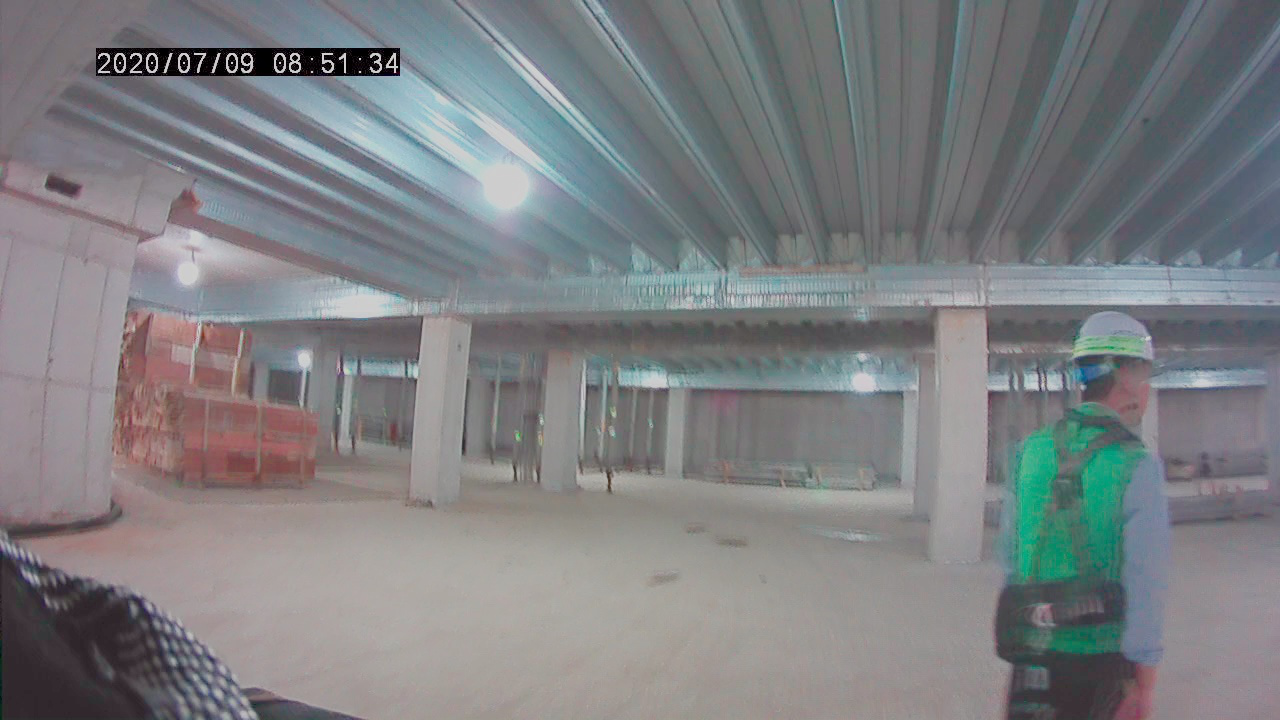

In [39]:
img = Image.open(TRAIN_IMAGE_PATH + '/' + json_label['image']['filename'])
img

In [37]:
# 실습해보세요.
x_min, y_min, x_max, y_max =annotations_list[0]['box'] # 표준화

from PIL import Image

# Training 이미지 경로 : TRIAN_IMAGE_PATH
img = Image.open(TRAIN_IMAGE_PATH + '/' + json_label['image']['filename'])

img_w, img_h = img.size
box_w, box_h = [(x_max-x_min), (y_max-y_min)]

In [40]:
yolo_label = []

center_x = (x_min+x_max) * 0.5 / img_w
center_y = (y_min+y_max) * 0.5 / img_h
dw = box_w / img_w
dh = box_h / img_h

yolo_label.append(str(annotations_list[0]['class'])+" "+str(center_x) + " " + str(center_y) + " " + str(dw) + " " + str(dh))
print(yolo_label)

['07 0.87109375 0.5006944444444444 0.065625 0.1486111111111111']


In [62]:
img_h

720

<font color="green">[실습문제]</font> 6. "data/training/labels" 디렉토리 내 .json 파일들을 YOLO labels 데이터 형태인 .txt로 변환하고 TRAIN_CONVERT_PATH  저장하세요. <br>
<font color="red">(단, annotation['middle classification'] 의 값이 '01' (중분류 : 안전보호구)인 경우만 yolo_label 리스트에 저장해주세요.) </font>

> [예시] yolo_label 리스트 저장 형태<br>
```
"0 0.11111 0.22222 0.33333 0.44444"
"1 0.11111 0.22222 0.33333 0.44444"
"1 0.11111 0.22222 0.33333 0.44444"
```


In [41]:
TRAIN_CONVERT_PATH = TRAIN_PATH + '/convert'

if not os.path.exists(TRAIN_CONVERT_PATH):
  os.mkdir(TRAIN_CONVERT_PATH)

In [43]:
# 실습해보세요.
# 전체 이미지 사이즈 가지고 텍스트 변환
def convert(img_size, box):
  img_w = img_size[0] # width
  img_h = img_size[1] # height

  x_min, y_min, x_max, y_max = box

  box_w, box_h = [(x_max-x_min), (y_max-y_min)] # 최대 - 최소

  center_x = (x_min+x_max) * 0.5 / img_w
  center_y = (y_min+y_max) * 0.5 / img_h
  
  # 표준화
  dw = box_w / img_w 
  dh = box_h / img_h
 
  return (center_x, center_y, dw, dh)

In [45]:
# 받아온 좌표들을 
def make_yolo_label(labels_list, data_path):
  convert_path = data_path + "/convert"

  if not os.path.exists(convert_path):
    os.mkdir(convert_path)

  for label in tqdm(labels_list, desc="CONVERT PROGRESS"):
    with open (label, "r") as f:
      json_label = json.load(f) # 라벨 불러와서 json_label에 넣기

    annotations_list = json_label['annotations']
    image_file = data_path + "/images/" + json_label['image']['filename']              # 이미지 파일명
    convert_file = convert_path + "/" + json_label['image']['filename'][:-4] + ".txt"
   
    image = Image.open(image_file)
    image_size = image.size # 이미지 사이즈 지정
    yolo_label = []
    for annotation in annotations_list :
      if 'box' in annotation:
        if annotation['middle classification'] == '01': # 중분류 -> 안전장비만 꺼내는 코드(안전보호구만 추출)
          class_id = int(annotation['class'])           # '01' = 안전장비 코드, class int로 변환
          box = annotation['box']
          (center_x, center_y, dw, dh) = convert(image_size, box)
          yolo_label.append(str(class_id) + " " + str(center_x) + " " + str(center_y) + " " + str(dw) + " " + str(dh)) 
    with open(convert_file , 'w') as f:
      f.write('\n'.join(yolo_label) + '\n')       


In [46]:
make_yolo_label(training_labels_list, TRAIN_PATH)

CONVERT PROGRESS:   0%|          | 0/4105 [00:00<?, ?it/s]

<font color="green">[실습문제]</font> 7. validation_data도 trainging 데이터처럼 json 형태의 labels 데이터를 yolo 학습을 위한 labels(.txt) 형태로 변환하여 저장해 주세요.
> 저장경로 : VALIDATION_CONVERT_PATH = VALIDATION_PATH + '/convert'

In [47]:
VALIDATION_CONVERT_PATH = VALIDATION_PATH + '/convert'

In [48]:
# 실습해보세요.
make_yolo_label(validation_labels_list, VALIDATION_PATH)


CONVERT PROGRESS:   0%|          | 0/109 [00:00<?, ?it/s]

<font color="green">[실습문제]</font> 8. training, validation의 labels 폴더 내 데이터를 변형을 완료시킨 데이터(.txt)로 대체해주세요. 
> [주의] 가급적 기존 json 형태의 데이터는 백업해두고 진행하세요.<br>

In [49]:
BACKUP_PATH = "/content/backup"

In [50]:
if not os.path.exists(BACKUP_PATH):
  os.mkdir(BACKUP_PATH)

In [51]:
# 실습해보세요.
!mv '{TRAIN_LABEL_PATH}' /content/backup/training
!mv '{VALIDATION_LABEL_PATH}' /content/backup/validation
!mv '{TRAIN_CONVERT_PATH}' '{TRAIN_LABEL_PATH}'
!mv '{VALIDATION_CONVERT_PATH}' '{VALIDATION_LABEL_PATH}' 

---

### 3) data.yaml 파일 생성하기

<font color="green">[실습문제]</font> 9. "data.yaml" 파일을 생성하고 내 라벨 클래스들과 경로를 입력해주세요.
* 데이터 경로 
> train : TRAIN_IMAGE_PATH<br>
> val : VAL_IMAGE_PATH
* 클래스 수 
> nc: 9
* 클래스 이름 
> names: ['None',<br>
> &emsp;&emsp;&emsp;&emsp;'안전벨트 착용',<br>
> &emsp;&emsp;&emsp;&emsp;'안전벨트 미착용',<br>
> &emsp;&emsp;&emsp;&emsp;'안전고리 결착',<br>
> &emsp;&emsp;&emsp;&emsp;'안전고리 미결착',<br>
> &emsp;&emsp;&emsp;&emsp;'안전화 착용',<br>
> &emsp;&emsp;&emsp;&emsp;'안전화 미착용',<br>
> &emsp;&emsp;&emsp;&emsp;'안전모 착용',<br>
> &emsp;&emsp;&emsp;&emsp;'안전모 미착용',] <br>

<font color="red">[Hint]</font> data.yaml 파일은 딕셔너리 형태로 되어 있습니다.

In [52]:
# 실습해보세요
data = {
    'train' : TRAIN_IMAGE_PATH,
    'val' : VALIDATION_IMAGE_PATH,
    'nc' : 9,
    'names' : [
        'None',
        '안전벨트 착용',
        '안전벨트 미착용',
        '안전고리 결착',
        '안전고리 미결착',
        '안전화 착용',
        '안전화 미착용',
        '안전모 착용',
        '안전모 미착용',
     ]
}

with open(DATA_PATH + '/data.yaml', 'w') as f:
  yaml.dump(data, f, default_flow_style=False, encoding=('utf-8'))


In [53]:
with open(DATA_PATH + '/data.yaml', 'r') as f:
  data_check = yaml.load(f, Loader=yaml.FullLoader)

In [54]:
data_check

{'names': ['None',
  '안전벨트 착용',
  '안전벨트 미착용',
  '안전고리 결착',
  '안전고리 미결착',
  '안전화 착용',
  '안전화 미착용',
  '안전모 착용',
  '안전모 미착용'],
 'nc': 9,
 'train': '/content/data/training/images',
 'val': '/content/data/validation/images'}

In [55]:
!cat '/content/data/training/labels/S2-O1301M03550.txt'

7 0.304296875 0.50625 0.09296875 0.16805555555555557
1 0.3171875 0.7965277777777777 0.1484375 0.40694444444444444
7 0.771484375 0.41180555555555554 0.21484375 0.4708333333333333
1 0.867578125 0.7340277777777777 0.26484375 0.5319444444444444
7 0.771484375 0.41180555555555554 0.21484375 0.4708333333333333


## 4. Yolov5 를 이용한 모델 학습
> https://github.com/ultralytics/yolov5/wiki/Train-Custom-Data/<br>
> ○ [Command] 
```# 코드로 형식 지정됨
 !python train.py --img 640 --epochs 3 --data coco.yaml --weights yolov5n.pt --batch 128 
                                                                  yolov5s            64
                                                                  yolov5m            40
                                                                  yolov5l            24
                                                                  yolov5x            16
```

> ○ [Properties]
>> --img: 입력 이미지 크기 <br>
>> --batch: 배치 크기 <br>
>> --epochs: 학습 epoch 수 <br>
>> --data: data.yaml 파일 경로 <br>
>> --cfg: 모델 구성 지정 <br>
>> --weights: 가중치에 대한 사용자 정의 경로를 지정<br>
>> --name: 모델이 저장 될 폴더 이름 <br>
>> --nosave: 최종 체크포인트만 저장<br>
>> --cache: 더 빠른 학습을 위해 이미지를 캐시<br>

> ○ [Select Model]<br>
><img src="https://github.com/ultralytics/yolov5/releases/download/v1.0/model_comparison.png" width="640px">

<font color="green">[실습문제]</font> 10. Yolov5s(small) 모델을 활용하여 학습하세요.
> img size : 416 <br>
> batch size : 16 <br>
> epochs : 5 <br>
> data : /content/data/data.yaml <br>
> weights : yolov5s.pt <br>
> name : safety_equipment_detection <br>

In [56]:
# 실습해보세요.
%cd ./yolov5
!python train.py --img 416 --batch 16 --epochs 5 --data /content/data/data.yaml --weights yolov5s.pt --name safety_equipment_detection

/content/yolov5
train: weights=yolov5s.pt, cfg=, data=/content/data/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=5, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=safety_equipment_detection, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.2-205-geef9057 Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0,

## 5. 모델 성능 확인
> Yolo에서는 모델의 성능(정확도)를 Mean Average Precision(mAP)를 통해 확인합니다. <br>
mAP가 높을수록 정확하고, 작을수록 부정확합니다. <br>
> AP를 계산할 때, precision-recall, IoU 와 연관이 있습니다. <br>


In [ ]:
# mAP를 높이려면 class 구분이 명확한 데이터 추가!

<font color="green">[실습문제]</font> 11. model summary를 확인하여 Class 별, 전체 mAP를 확인해 보세요.

In [ ]:
# 실습해보세요.


```
# 코드로 형식 지정됨
Model summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 56/56 [00:18<00:00,  3.05it/s]
                   all       1766       6808      0.963      0.608      0.646      0.403
                  head       1766       1803      0.942      0.896      0.944       0.59
                helmet       1766       4863      0.948      0.927      0.971      0.606
                person       1766        142          1          0     0.0243     0.0136
```



## 6. Test 데이터 추론하기 
* 해당 결과는 runs/detect/exp/ 위치에 저장됩니다.
> ○ [Command] 
``` # 코드로 형식 지정됨
!python detect.py --source 0  # webcam
                           img.jpg  # image
                           vid.mp4  # video
                           screen  # screenshot
                           path/  # directory
                           'path/*.jpg'  # glob
                           'https://youtu.be/Zgi9g1ksQHc'  # YouTube
                           'rtsp://example.com/media.mp4'  # RTSP, RTMP, HTTP stream
```
> ○ [Properties] 
>> -- source : test 데이터(이미지, 영상 파일 혹은 폴더) 경로 <br>
>> -- weights : 학습이 완료된 weight 파일 경로 (pt 형식) <br>
>> -- conf : conf_threshold 값 (0 ~ 1 사이의 값)


* TEST 데이터 다운로드하기(아래의 코드를 실행하세요)


In [57]:
# 현재 디렉토리 확인
%pwd
%cd /content

/content


In [58]:
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [59]:
import gdown
import zipfile

In [60]:
test_file_id = "14PsLrMhL2v7n3dYjv2JOFWF6iIUFYhyQ"

def goolge_drive_download (file_id): 
  google_path = 'https://drive.google.com/uc?id='
  output_name = 'download_file.zip'

  gdown.download(google_path+file_id,output_name,quiet=False)

  zip_file = "/content/download_file.zip"

  
  with zipfile.ZipFile(zip_file) as z:
    z.extractall("/content")

  os.remove(zip_file) 

In [61]:
goolge_drive_download(test_file_id)

Access denied with the following error:



 	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=14PsLrMhL2v7n3dYjv2JOFWF6iIUFYhyQ 



FileNotFoundError: ignored

<font color="green">[실습문제]</font> 12-1. 이미지를 소스로 한 객체 검출하기 
> 경로 "TEST_IMAGE_PATH" 의 이미지 파일들의 객체를 검출해 보세요.  
> [조건] 
> ① img size : 416, ② IOU Threshold : 0.5, ③ 모델 weights : best.pt

In [ ]:
# 실습해보세요
%cd /content/yolov5
!python detect.py --source '{TEST_IMAGE_PATH}' --weights /content/yolov5/runs/train/safety_equipment/weights/best.pt --img 416 --conf 0.1

/content/yolov5
detect: weights=['/content/yolov5/runs/train/safety_equipment/weights/best.pt'], source=/content/data/test/images/, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v6.2-198-gacff977 Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 157 layers, 7034398 parameters, 0 gradients, 15.8 GFLOPs
image 1/12 /content/data/test/images/test_image_01.jpg: 256x416 3 안전벨트 착용s, 5 안전모 착용s, 11.5ms
image 2/12 /content/data/test/images/test_image_02.jpg: 256x416 (no detections), 8.4ms
image 3/12 /content/data/test/images/test_image_03.jpg: 256x416 3 안전벨트 착용s, 2 안전화 착용s, 2 안전모 착용s, 7.3ms
image 4/12

<font color="green">[실습문제]</font> 12-2. detect가 완료된 이미지를 확인해 보세요.


In [ ]:
# 필요 라이브러리 불러오기
from PIL import Image               # to load images
from IPython.display import display # to display images

In [ ]:
# 실습해보세요.
detect_image_path = "/content/yolov5/runs/detect/exp"  #detect가 완료된 파일의 경로

for i in glob.glob(detect_image_path + '/*.jpg'):
  img = Image.open(i)
  img_resize = img.resize((640, 360))
  display(img_resize)
  print('\n')


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# 필요 라이브러리 불러오기
from PIL import Image               # to load images
from IPython.display import display # to display images